# First Improvement

## Import and Basic Setup

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
from torchvision import datasets, transforms
from google.colab import drive
import matplotlib.gridspec as gridspec


drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_dir = '/content/drive/My Drive/CV_Project/datasets/train'
test_dir  = '/content/drive/My Drive/CV_Project/datasets/test'


Mounted at /content/drive


## Data augmentation

We perform data augmentation by random **horizontal flip** (p=0.75), **random resized crop** (chosen with a random scale between 80% and 100% of the original image) and **random rotation** (degrees between [-10, +10]), doubling the training set variation, applying it only to the train fraction of the training images.

In [ ]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.75),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 255.0)
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 255.0)
])


train_val_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=transforms.Grayscale(num_output_channels=1)
)


dataset_size = len(train_val_dataset)
train_len = int(0.85 * dataset_size)
val_len   = dataset_size - train_len

train_subset, val_subset = random_split(
    train_val_dataset,
    [train_len, val_len]
)

train_subset.dataset.transform = train_transform
val_subset.dataset.transform   = val_test_transform


train_original = Subset(train_val_dataset, train_subset.indices)
train_original.dataset.transform = val_test_transform

train_augmented = Subset(train_val_dataset, train_subset.indices)
train_augmented.dataset.transform = train_transform

train_dataset = ConcatDataset([train_original, train_augmented])

val_dataset = Subset(train_val_dataset, val_subset.indices)
val_dataset.dataset.transform = val_test_transform


test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=val_test_transform
)

print(f"Original train set size: {len(train_original)}")
print(f"Current train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Original train set size: 1275
Current train set size: 2550
Validation set size: 225
Test set size: 2985


## Batch normalization

We add batch normalization before each ReLU to stabilize and accelerate training.

We also increase filter sizes. This can help the network to learn higher-level features at deeper layers.

We also add Dropout after some layers to further help regularization.

Some layers are added to increase the depth of the model.

In [ ]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=15):
        super(ImprovedCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(num_features=8)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.bn2   = nn.BatchNorm2d(num_features=16)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=7, stride=1, padding=3)
        self.bn3   = nn.BatchNorm2d(num_features=32)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, stride=1, padding=2)
        self.bn4   = nn.BatchNorm2d(num_features=64)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout = nn.Dropout(p=0.3)

        self.fc1 = None
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.pool2(nn.functional.relu(self.bn2(self.conv2(x))))
        x = self.pool3(nn.functional.relu(self.bn3(self.conv3(x))))
        x = self.pool4(nn.functional.relu(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)
        if self.fc1 is None:
          self.fc1 = nn.Linear(x.size(1), 256).to(x.device)
        x = self.dropout(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


## Weight inizialization

As before, we can keep the same initialization approach (normal distribution with mean=0, std=0.01)

In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.01)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

## Dataloaders and training/validation

We now create our Dataloaders (with augmented train set, normal val set). Keep the same batch size.

In [ ]:
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

## Single model training

In [ ]:
def train_model(
    lr,
    wd,
    opt_name,
    train_loader,
    val_loader,
    test_loader=None,
    num_epochs=30,
    patience=5,
    compute_accuracy=False
):

    model = ImprovedCNN(num_classes=15).to(device)
    model.apply(initialize_weights)
    criterion = nn.CrossEntropyLoss()

    if opt_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    elif opt_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    else:
        raise ValueError("Unknown optimizer name. Choose from ['SGD', 'Adam'].")

    best_val_loss = np.inf
    epochs_no_improve = 0

    train_losses = []
    val_losses   = []

    train_accuracies = []
    val_accuracies   = []

    train_dataset_size = len(train_loader.dataset)
    val_dataset_size   = len(val_loader.dataset)

    for epoch in range(num_epochs):
        model.train()
        train_loss_sum  = 0.0
        train_correct   = 0
        train_total     = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * images.size(0)

            if compute_accuracy:
                _, predicted = torch.max(outputs, 1)
                train_correct += (predicted == labels).sum().item()
                train_total   += labels.size(0)

        epoch_train_loss = train_loss_sum / train_dataset_size
        train_losses.append(epoch_train_loss)

        if compute_accuracy:
            epoch_train_acc = 100.0 * train_correct / train_total
            train_accuracies.append(epoch_train_acc)

        model.eval()
        val_loss_sum  = 0.0
        val_correct   = 0
        val_total     = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss_sum += loss.item() * images.size(0)

                if compute_accuracy:
                    _, predicted = torch.max(outputs, 1)
                    val_correct += (predicted == labels).sum().item()
                    val_total   += labels.size(0)

        epoch_val_loss = val_loss_sum / val_dataset_size
        val_losses.append(epoch_val_loss)

        if compute_accuracy:
            epoch_val_acc = 100.0 * val_correct / val_total
            val_accuracies.append(epoch_val_acc)

            print(f"Epoch [{epoch+1}/{num_epochs}] "
                  f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% || "
                  f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        else:
            print(f"Epoch [{epoch+1}/{num_epochs}] "
                  f"Train Loss: {epoch_train_loss:.4f} || "
                  f"Val Loss: {epoch_val_loss:.4f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("\nEarly stopping triggered.")
                break

    test_accuracy = None
    if test_loader is not None:
        model.eval()
        test_correct = 0
        test_total   = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                test_correct += (predicted == labels).sum().item()
                test_total   += labels.size(0)

        test_accuracy = 100.0 * test_correct / test_total
        print(f"\nTest Accuracy: {test_accuracy:.2f}%\n")
        print("---------------------------------------------------------------------------------------------\n")

    return {
        'model'           : model,
        'best_val_loss'   : best_val_loss,
        'train_losses'    : train_losses,
        'val_losses'      : val_losses,
        'train_accuracies': train_accuracies if compute_accuracy else None,
        'val_accuracies'  : val_accuracies   if compute_accuracy else None,
        'test_accuracy'   : test_accuracy
    }


## Optimizer improvements

We play with different optimization parameters.
Learning rate and momentun are set as the best values found in the baseline model (0.001 and 0.9, respectively)


In [ ]:
learning_rate = 1e-3
weight_decays = [0.0, 1e-5, 1e-4, 5e-4]
optimizers    = ['SGD', 'Adam']
num_epochs    = 30
patience      = 5

tuning_results = []

print("=== START HYPERPARAMETER TUNING ===\n")

for wd in weight_decays:
    for opt_name in optimizers:
        print(f"Training with learning rate = {learning_rate}, weight decay = {wd}, optimizer = {opt_name}\n")

        results_dict = train_model(
            lr=learning_rate,
            wd=wd,
            opt_name=opt_name,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            num_epochs=num_epochs,
            patience=patience,
            compute_accuracy=True
        )
        model         = results_dict['model']
        test_acc      = results_dict['test_accuracy']
        best_val_loss = results_dict['best_val_loss']

        tuning_results.append({
            'lr'           : learning_rate,
            'weight_decay' : wd,
            'optimizer'    : opt_name,
            'test_accuracy': test_acc,
            'val_loss'     : best_val_loss
        })
        print()

tuning_df = pd.DataFrame(tuning_results)
print("=== TUNING RESULTS ===")
print(tuning_df, "\n")

best_result = tuning_df.loc[tuning_df['test_accuracy'].idxmax()]
best_lr     = best_result['lr']
best_wd     = best_result['weight_decay']
best_opt    = best_result['optimizer']
print(f"BEST HYPERPARAMS => weight_decay={best_wd}, optimizer={best_opt}")
print(f"Best Test Acc = {best_result['test_accuracy']:.2f}%\n")

=== START HYPERPARAMETER TUNING ===

Training with learning rate = 0.001, weight decay = 0.0, optimizer = SGD

Epoch [1/30] Train Loss: 2.6625, Train Acc: 11.25% || Val Loss: 2.6274, Val Acc: 18.67%
Epoch [2/30] Train Loss: 2.4739, Train Acc: 24.82% || Val Loss: 2.3608, Val Acc: 29.33%
Epoch [3/30] Train Loss: 2.2390, Train Acc: 30.55% || Val Loss: 2.2422, Val Acc: 31.11%
Epoch [4/30] Train Loss: 2.0304, Train Acc: 38.55% || Val Loss: 2.0320, Val Acc: 32.89%
Epoch [5/30] Train Loss: 1.8398, Train Acc: 45.29% || Val Loss: 1.9565, Val Acc: 40.44%
Epoch [6/30] Train Loss: 1.6566, Train Acc: 50.86% || Val Loss: 1.9559, Val Acc: 33.33%
Epoch [7/30] Train Loss: 1.4655, Train Acc: 58.94% || Val Loss: 2.3745, Val Acc: 27.11%
Epoch [8/30] Train Loss: 1.3072, Train Acc: 64.00% || Val Loss: 1.9395, Val Acc: 35.11%
Epoch [9/30] Train Loss: 1.1283, Train Acc: 71.14% || Val Loss: 1.7400, Val Acc: 40.44%
Epoch [10/30] Train Loss: 0.9957, Train Acc: 75.29% || Val Loss: 1.4615, Val Acc: 55.56%
Epoch [1

## Ensemble
With the best parameters found, we employ an ensemble of 5 networks, trained independently. Then we use the arithmetic average of the outputs to assign the class, as in [Szegedy et al., 2015](https://dl.acm.org/doi/pdf/10.1145/3065386).

=== TRAINING ENSEMBLE WITH BEST PARAMS ===

Training model #1 / 5 (Ensemble)

Epoch [1/30] Train Loss: 2.4214, Train Acc: 21.69% || Val Loss: 2.1990, Val Acc: 24.00%
Epoch [2/30] Train Loss: 1.8073, Train Acc: 42.59% || Val Loss: 1.9935, Val Acc: 33.33%
Epoch [3/30] Train Loss: 1.3746, Train Acc: 57.18% || Val Loss: 1.6998, Val Acc: 44.89%
Epoch [4/30] Train Loss: 1.0934, Train Acc: 67.65% || Val Loss: 1.7372, Val Acc: 41.78%
Epoch [5/30] Train Loss: 0.8390, Train Acc: 75.18% || Val Loss: 1.6542, Val Acc: 48.89%
Epoch [6/30] Train Loss: 0.5931, Train Acc: 84.16% || Val Loss: 1.6307, Val Acc: 51.11%
Epoch [7/30] Train Loss: 0.4349, Train Acc: 89.37% || Val Loss: 1.3939, Val Acc: 53.78%
Epoch [8/30] Train Loss: 0.2915, Train Acc: 93.73% || Val Loss: 1.8101, Val Acc: 48.44%
Epoch [9/30] Train Loss: 0.2364, Train Acc: 95.22% || Val Loss: 1.9072, Val Acc: 47.56%
Epoch [10/30] Train Loss: 0.1643, Train Acc: 97.18% || Val Loss: 1.4895, Val Acc: 59.11%
Epoch [11/30] Train Loss: 0.1251, Train A

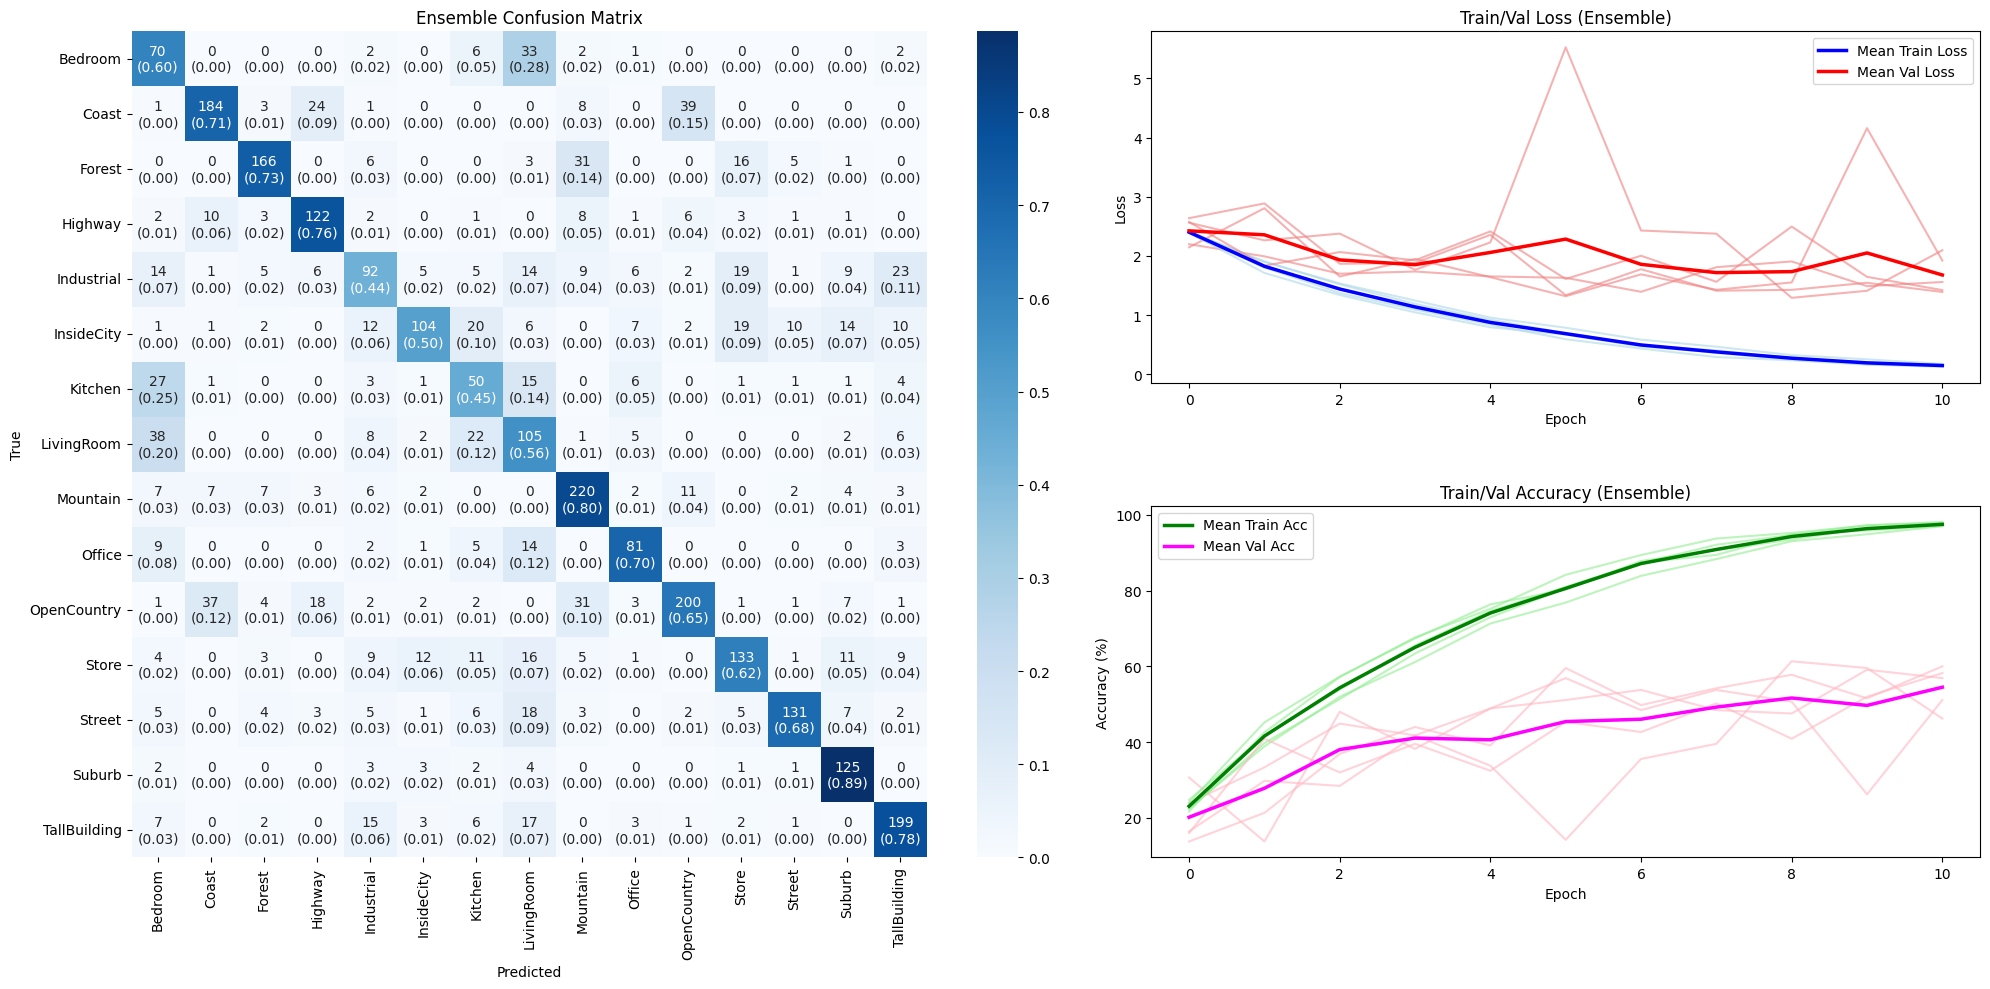

In [ ]:
n_ensemble_models = 5
ensemble_models   = []
train_losses_runs = []
val_losses_runs   = []
train_acc_runs    = []
val_acc_runs      = []

print("=== TRAINING ENSEMBLE WITH BEST PARAMS ===")
for i in range(n_ensemble_models):
    print()
    if i > 0:
        print("---------------------------------------------------------------------------------------------\n")
    print(f"Training model #{i+1} / {n_ensemble_models} (Ensemble)\n")

    results_dict = train_model(
        lr=best_lr,
        wd=best_wd,
        opt_name=best_opt,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=None,
        num_epochs=30,
        patience=5,
        compute_accuracy=True
    )

    ensemble_models.append(results_dict['model'])
    train_losses_runs.append(results_dict['train_losses'])
    val_losses_runs.append(results_dict['val_losses'])
    train_acc_runs.append(results_dict['train_accuracies'])
    val_acc_runs.append(results_dict['val_accuracies'])


print("\n=== TESTING THE ENSEMBLE ===\n")

all_labels = []
all_preds  = []
test_correct = 0
test_total   = 0

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    sum_logits = None
    for model_i in ensemble_models:
        model_i.eval()
        with torch.no_grad():
            outputs = model_i(images)
        if sum_logits is None:
            sum_logits = outputs
        else:
            sum_logits += outputs

    avg_logits = sum_logits / n_ensemble_models
    _, predicted = torch.max(avg_logits, 1)

    test_correct += (predicted == labels).sum().item()
    test_total   += labels.size(0)

    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(predicted.cpu().numpy())

ensemble_acc = 100.0 * test_correct / test_total
print(f"\nEnsemble Test Accuracy: {ensemble_acc:.2f}%\n")

cm = confusion_matrix(all_labels, all_preds)
row_sums = cm.sum(axis=1, keepdims=True)
normalized_cm = cm / row_sums

annot = np.empty(cm.shape, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        raw_count = cm[i, j]
        norm_val  = normalized_cm[i, j]
        annot[i, j] = f"{raw_count}\n({norm_val:.2f})"

class_names = test_dataset.classes


fig = plt.figure(figsize=(20, 10))

outer = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1.2, 1])

ax_cm = fig.add_subplot(outer[0])

right_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[1], hspace=0.35)
ax_loss = fig.add_subplot(right_gs[0])
ax_acc  = fig.add_subplot(right_gs[1])

sns.heatmap(
    normalized_cm,
    annot=annot,
    fmt="",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    ax=ax_cm
)
ax_cm.set_title("Ensemble Confusion Matrix")
ax_cm.set_xlabel("Predicted")
ax_cm.set_ylabel("True")

light_train_color = "lightblue"
light_val_color   = "lightcoral"

min_len_train_loss = min(len(losses) for losses in train_losses_runs)
min_len_val_loss   = min(len(losses) for losses in val_losses_runs)

for i in range(n_ensemble_models):
    ax_loss.plot(train_losses_runs[i][:min_len_train_loss],
                 color=light_train_color, alpha=0.6)
    ax_loss.plot(val_losses_runs[i][:min_len_val_loss],
                 color=light_val_color, alpha=0.6)

mean_train_losses = np.mean([losses[:min_len_train_loss] for losses in train_losses_runs], axis=0)
mean_val_losses   = np.mean([losses[:min_len_val_loss]   for losses in val_losses_runs],   axis=0)

ax_loss.plot(mean_train_losses, color="blue", label="Mean Train Loss", linewidth=2.5)
ax_loss.plot(mean_val_losses,   color="red",  label="Mean Val Loss",   linewidth=2.5)

ax_loss.set_title("Train/Val Loss (Ensemble)")
ax_loss.set_xlabel("Epoch")
ax_loss.set_ylabel("Loss")
ax_loss.legend()

light_train_color_acc = "lightgreen"
light_val_color_acc   = "lightpink"

min_len_train_acc = min(len(acc) for acc in train_acc_runs if acc is not None)
min_len_val_acc   = min(len(acc) for acc in val_acc_runs   if acc is not None)

for i in range(n_ensemble_models):
    ax_acc.plot(train_acc_runs[i][:min_len_train_acc],
                color=light_train_color_acc, alpha=0.6)
    ax_acc.plot(val_acc_runs[i][:min_len_val_acc],
                color=light_val_color_acc, alpha=0.6)

mean_train_acc = np.mean([acc[:min_len_train_acc] for acc in train_acc_runs], axis=0)
mean_val_acc   = np.mean([acc[:min_len_val_acc]   for acc in val_acc_runs],   axis=0)

ax_acc.plot(mean_train_acc, color="green", label="Mean Train Acc", linewidth=2.5)
ax_acc.plot(mean_val_acc,   color="magenta", label="Mean Val Acc", linewidth=2.5)

ax_acc.set_title("Train/Val Accuracy (Ensemble)")
ax_acc.set_xlabel("Epoch")
ax_acc.set_ylabel("Accuracy (%)")
ax_acc.legend()

plt.tight_layout()
plt.show()